In [1]:
import jax.numpy as np
from jax import jit, grad, vmap
from jax import value_and_grad
import numpy as onp
import meshzoo
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from scipy.spatial.distance import cdist
from MDAnalysis import Universe

RDKit WARNING: [11:07:53] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
radius_lookup = {}
radius_lookup['C']=1.7
radius_lookup[6]=1.7

radius_lookup['H']=1.0
radius_lookup[1]=1.0

radius_lookup['N']=1.625
radius_lookup[7]=1.625

radius_lookup['O']=1.49
radius_lookup[8]=1.49

radius_lookup['S']=1.782
radius_lookup[16]=1.782

In [113]:
u=Universe('kras.pdb')
atoms =u.atoms
atom_centres = atoms.positions
radii = np.array([radius_lookup[i] for i in atoms.types])


In [114]:
#import mdtraj as md
#pdb = md.load('kras.pdb')
#sasa =md.shrake_rupley(pdb).sum()

In [115]:
#put at COM:
atom_centres = (atom_centres - np.mean(atom_centres,0))

In [116]:
def golden_spiral(num_pts, radius):
    if radius==0:
        return np.array([[0,0,0]])
    indices = np.arange(0, num_pts) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

def plotly_scatter(pointsets, sizes=None, opacity=0.8):
    data = []
    #sizes = [np.ones(len(p))*s for p,s in zip(pointsets,sizes)]
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        markerparams=dict(size=s,sizemode='area',opacity=opacity)
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker=markerparams)
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)

@jit
def E_fn(points1, points2):
    ri = np.expand_dims(points1, 0)
    rj = np.expand_dims(points2, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij


@jit
def get_atom_fraction(i, radii, sphere_points, atom_centres):
    translated_sphere_points = sphere_points*radii[i]+atom_centres[i]
    distance_to_all_atoms = E_fn(translated_sphere_points, atom_centres)
    nearest_atoms = distance_to_all_atoms.argsort(0)[0]
    distance_mask =  distance_to_all_atoms.min(0)>(radii[nearest_atoms]-1e-4)
    return distance_mask.sum() / distance_mask.shape[0]

vget_atom_fraction = vmap(get_atom_fraction, in_axes=(0, None, None, None))



In [253]:
#create a spherical mesh made of triangles
points, cells = meshzoo.icosa_sphere(150)
atom_maxmin = onp.max(atom_centres,0)-onp.min(atom_centres,0)
#increase size of mesh to cover all atoms plus a buffer:
points = points*(atom_maxmin+10)/2 #2 angstrom buffer

In [254]:
plotly_scatter([atom_centres, points[onp.random.choice(range(len(points)), 400, replace=False)]], [5, 2])

In [255]:
##Collect all unique bonds:
allbonds = onp.zeros([cells.shape[0]*3,2])
for count, tri in enumerate(cells):
    allbonds[(count*3)][0] = min(tri[0], tri[1])
    allbonds[(count*3)][1] = max(tri[0], tri[1])
    allbonds[(count*3+1)][0] = min(tri[0], tri[2])
    allbonds[(count*3+1)][1] = max(tri[0], tri[2])
    allbonds[(count*3+2)][0] = min(tri[1], tri[2])
    allbonds[(count*3+2)][1] = max(tri[1], tri[2])
    
allbonds = onp.unique(allbonds,axis=0).astype(int)

In [257]:
#calculate SASA using the shrake rupley approach:
sphere_points = golden_spiral(150, 1)
atom_range = np.arange(atom_centres.shape[0])

In [258]:


#sasa = (vget_atom_fraction(atom_range, radii, sphere_points, atom_centres)*4*np.pi*radii**2).sum()


In [259]:
#Per triangle surface area:
per_tri_sa = sasa / cells.shape[0]

#assuming equilateral triangles, this would be the sidelength that has this area:
optimum_sidelength = (2/3)*(3**0.75)*(per_tri_sa**0.5)

In [260]:
alldistances = E_fn(atom_centres, points)

In [261]:
alldistances.shape

(225002, 2668)

In [262]:
alldistances = E_fn(atom_centres, points)
num = 3
#neighbour list:
top = onp.argpartition(onp.array(alldistances), num, axis=1)[:, :num]

In [263]:
points.max(0)

DeviceArray([27.778 , 24.793 , 25.1645], dtype=float32)

In [264]:
atom_centres.max(0)

DeviceArray([23.245468, 19.058598, 18.553688], dtype=float32)

In [265]:
np.linalg.norm(points-atom_centres[top[:,0]], axis=1)

DeviceArray([4.608633 , 8.067202 , 8.6891   , ..., 7.8976007, 7.877311 ,
             7.946352 ], dtype=float32)

In [266]:
lj(np.linalg.norm(points-atom_centres[top[:,0]], axis=1))

DeviceArray([-0.03826794, -0.00642914, -0.00500175, ..., -0.00690416,
             -0.00696388, -0.00676325], dtype=float32)

In [267]:

calc_neighbour_distances(p, a, radii, t, 0).min()

DeviceArray(0.23754752, dtype=float32)

In [268]:
p = points.copy()
a = atom_centres.copy()
t = top.copy()

lj(calc_neighbour_distances(p, a, radii, t, 0)+calc_neighbour_distances(p, a, radii, t, 1)+calc_neighbour_distances(p, a, radii, t, 2)).sum()


DeviceArray(-265.7574, dtype=float32)

In [209]:
@jit
def calc_neighbour_distances(p, a, r, t,i):
    return np.linalg.norm(p-a[t[:,i]], axis=1)-r[t[:,i]]

@jit    
def lj(distances, epsilon=0.85):#epsilon0.7 works good
    #inverse = 2 / (distances +2**(2/3))
    #lennard_jones = epsilon*( (inverse)**6 - 4*(inverse)**3)
    inverse = 2 / (distances +(7/2)**(1/3))
    lennard_jones = epsilon*( (inverse)**7 - 4*(inverse)**4)
    return lennard_jones

In [269]:
@jit 
def get_bond_lengths(pos, bonds):
    return np.linalg.norm(pos[bonds][:,0,:]-pos[bonds][:,1,:], axis=1)

@jit
def loss(p, a, b, c, radii, t):
    neighbour_distances = calc_neighbour_distances(p, a, radii, t, 0)+calc_neighbour_distances(p, a, radii, t, 1)+calc_neighbour_distances(p, a, radii, t, 2)
    lj_term= lj(neighbour_distances).sum()
    bond_lengths = get_bond_lengths(p, b)*10
    bond_term = (bond_lengths-optimum_sidelength*2.5)**3
    
    return lj_term+bond_term.sum()


In [270]:
from jax import value_and_grad

In [271]:
print(loss(points, atom_centres, allbonds,cells, radii, top))
gl = value_and_grad(loss)
print(gl(points, atom_centres, allbonds, cells, radii, top))

851527.6
(DeviceArray(851527.7, dtype=float32), DeviceArray([[-1.1563258e-01,  8.2931921e-02, -5.4450000e-05],
             [ 1.1519361e-01,  8.1828110e-02, -6.8900063e-06],
             [-1.1525205e-01, -8.1798360e-02,  1.8674338e-05],
             ...,
             [-4.0916818e-01,  5.1208174e-01,  3.7480611e-03],
             [-4.0916803e-01,  5.1208144e-01, -3.7548440e-03],
             [-4.0484694e-01,  4.9796143e-01, -2.6975993e-06]],            dtype=float32))


In [272]:
#copy so we don't change the original starting points, making it easier to do repeats
positions = points.copy()

avg_sq_grad = np.zeros_like(positions)
gamma=0.9
eps=1e-8
mass = 1
lr = 0.1 #step size

losses = onp.zeros(50000)

for _ in tqdm_notebook(range(15000)):
    if (_+1)%5000==0:
        alldistances = E_fn(atom_centres, positions)
        num = 3
        #neighbour list:
        top = onp.argpartition(onp.array(alldistances), num, axis=1)[:, :num]
        fig,ax = plt.subplots()
        ax.plot(losses-losses.min())
        plt.yscale('log')
        fig.savefig('losses.png')
        plt.close(fig)
    v,g = gl(positions, atom_centres, allbonds, cells, radii, top)
    losses[_]=v
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1. - gamma)
    newpos = positions - lr * g / np.sqrt(avg_sq_grad + eps)    
    print(np.max(np.linalg.norm(positions-newpos, axis=1)))
    positions=newpos

<ipython-input-272-eb61b365b2df>:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.5477228
0.5477222
0.5477228
0.5477228
0.5477228
0.5477228
0.5477222
0.54246116
0.38301775
0.40070057
0.36403486
0.3222983
0.3529399
0.3687542
0.36748484
0.37683338
0.30841824
0.32383084
0.3421645
0.3525527
0.36989635
0.39974782
0.43408838
0.45612308
0.44934422
0.44971454
0.46331123
0.47104305
0.5050966
0.5063582
0.5309969
0.52191305
0.51801926
0.5319649
0.5345029
0.5326959
0.5360606
0.5389133
0.54193455
0.5370663
0.5401939
0.54454
0.541423
0.5406953
0.5420684
0.5402631
0.5418348
0.53722584
0.5360792
0.5304228
0.53510237
0.53584296
0.529289
0.5374626
0.5400571
0.5385941
0.54116684
0.5387493
0.54051244
0.54166496
0.54154915
0.5396595
0.54524356
0.5424416
0.5421049
0.54497206
0.54354787
0.54390156
0.5424332
0.5423368
0.5429629
0.5385117
0.5347175
0.53535557
0.542236
0.54165775
0.5371957
0.53959316
0.5425741
0.54132915
0.5425391
0.53981704
0.54175633
0.53999144
0.5430216
0.545702
0.5389876
0.54045093
0.54064596
0.54105616
0.5398968
0.538133
0.5414858
0.54186845
0.54559773
0.5374219
0.539

0.54110384
0.5422201
0.5410927
0.5413003
0.5392415
0.5405565
0.5381249
0.5441159
0.54280216
0.5398001
0.541067
0.5373476
0.54481286
0.5436428
0.54348195
0.540773
0.5399081
0.5398377
0.5402256
0.54212666
0.53633964
0.5344229
0.5393466
0.54389644
0.53933287
0.5415581
0.53921586
0.5373036
0.53951156
0.541191
0.5409503
0.54269314
0.5427887
0.5414678
0.54045415
0.54198366
0.54416806
0.54322463
0.5404358
0.54055136
0.53825253
0.53610283
0.5414053
0.5384215
0.54319215
0.5423219
0.5397076
0.536927
0.5386771
0.54342556
0.5358916
0.542882
0.54215497
0.5377148
0.542488
0.5432143
0.5413676
0.5389139
0.54065734
0.5427331
0.54062176
0.5396808
0.54363865
0.53668624
0.5359286
0.54150593
0.53300214
0.54319257
0.54222286
0.5426505
0.53959614
0.54577065
0.5448347
0.5427279
0.54400986
0.54010713
0.5429824
0.5401998
0.5389166
0.5424746
0.54555595
0.537871
0.5434385
0.53602296
0.53981084
0.5402636
0.5398704
0.539582
0.5404115
0.5379971
0.5434659
0.5389095
0.5450923
0.5390531
0.5440082
0.53897196
0.54263276


KeyboardInterrupt: 

In [ ]:
for _ in tqdm_notebook(range(15000)):
    if (_+1)%5000==0:
        alldistances = E_fn(atom_centres, positions)
        num = 3
        #neighbour list:
        top = onp.argpartition(onp.array(alldistances), num, axis=1)[:, :num]
        fig,ax = plt.subplots()
        ax.plot(losses-losses.min())
        plt.yscale('log')
        fig.savefig('losses.png')
        plt.close(fig)
    v,g = gl(positions, atom_centres, allbonds, cells, radii, top)
    losses[_]=v
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1. - gamma)
    newpos = positions - lr * g / np.sqrt(avg_sq_grad + eps)    
    print(v, np.max(np.linalg.norm(positions-newpos, axis=1)))
    positions=newpos

<ipython-input-278-22dee0d45a5c>:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



2802409.2 0.5439476
2788562.8 0.5418555
2799392.2 0.54381967
2826985.5 0.54442483
2842135.8 0.5449626
2843442.0 0.5448352
2855667.5 0.5440935
2871646.5 0.5457972
2925628.2 0.54517436
2956462.5 0.54317355
3016998.2 0.5444269
2987325.5 0.5446926
2976799.5 0.5414716
3030968.5 0.5457234
3018636.8 0.5426324
3004176.0 0.54197663
2992606.5 0.5451474
2933790.0 0.54220974
2939298.0 0.5452353
2884344.0 0.5442249
2874437.8 0.54164
2877997.0 0.54203373
2877496.8 0.5417745
2857443.8 0.5442254
2873681.0 0.54147726
2899832.2 0.5436319
2933071.2 0.54401803
2942267.2 0.5427612
2940657.0 0.5429241
2912420.0 0.54209954
2898018.2 0.54383045
2903698.8 0.5432148
2917079.2 0.5444309
2945248.5 0.54574454
2962715.0 0.5440635
2944340.2 0.54192895
2935736.5 0.54681677
2947114.2 0.54531395
2941626.5 0.54233885
2947363.5 0.54289716
2941184.2 0.54282755
2945266.0 0.54267126
2904408.0 0.54145646
2890720.5 0.5419189
2900979.0 0.54348165
2902346.8 0.54255766
2917940.2 0.5453583
2909489.5 0.5435771
2875867.2 0.5409138


2859345.5 0.5441868
2898336.5 0.5417385
2908982.5 0.5455565
2905269.5 0.54318196
2903709.2 0.5449035
2907487.0 0.54447997
2868555.8 0.5448733
2841295.2 0.54767543
2837450.8 0.54293495
2834777.8 0.5461148
2857583.8 0.54299325
2877940.0 0.5448959
2902960.0 0.5422681
2927362.8 0.5450536
2949488.8 0.5434268
2984726.2 0.5451532
2951134.8 0.540458
2934556.0 0.5447556
2909955.0 0.5428805
2898620.8 0.54363143
2869181.2 0.54185194
2859105.2 0.5431443
2885247.2 0.54360837
2871213.0 0.54428726
2840392.8 0.5457003
2792149.8 0.5454087
2796922.8 0.5454684
2833528.5 0.5456735
2833882.5 0.5429963
2811890.5 0.542026
2796403.2 0.5423054
2796975.2 0.54512256
2856963.8 0.54555833
2931253.8 0.5460638
2977127.8 0.54385996
3006118.2 0.5427125
3010055.5 0.5442455
3011764.5 0.542569
2980368.5 0.5431971
2955717.8 0.5442126
2927592.8 0.542955
2899138.5 0.5440087
2885930.5 0.5439386
2885252.5 0.542955
2870352.2 0.54612786
2873852.2 0.54327106
2866610.2 0.5452616
2827946.0 0.5428322
2805031.8 0.54576236
2758069.2 

3037520.5 0.54400736
2992015.2 0.5460425
2952648.8 0.54558986
2901204.0 0.54542196
2850279.2 0.54606545
2751849.0 0.54663885
2639612.0 0.54214466
2622812.8 0.5422562
2623903.2 0.54486024
2615165.5 0.543081
2624958.2 0.5420987
2617976.2 0.54164654
2667046.5 0.539679
2728694.2 0.5445106
2810802.8 0.5421355
2915124.5 0.5438896
2986858.0 0.54339945
2988851.2 0.5428077
2992582.5 0.54235834
3029304.5 0.5450263
3025769.5 0.54444706
3019407.0 0.54701185
3004056.0 0.54363567
2963893.8 0.545669
2885113.0 0.5447264
2876376.8 0.546688
2859485.0 0.5437282
2825945.0 0.5444387
2791718.2 0.54545903
2801641.2 0.5454794
2743667.5 0.5403493
2722208.0 0.54295784
2710931.2 0.54302996
2705482.8 0.5431669
2735264.5 0.5446096
2760260.0 0.5438259
2812601.5 0.544602
2852315.0 0.54729706
2872642.0 0.54658645
2912318.5 0.5456571
2930334.0 0.5436626
2946233.5 0.54398954
2935652.0 0.5444836
2926892.5 0.54425734
2923986.8 0.5444667
2920281.0 0.54520637
2882594.0 0.5433504
2856299.2 0.54407644
2807054.8 0.5472764
279

2770478.8 0.54239345
2805863.5 0.543533
2816661.0 0.5416577
2807167.2 0.54401255
2797975.2 0.5422898
2748052.2 0.5427754
2710507.5 0.54483163
2701924.0 0.5408503
2724882.8 0.5440167
2708686.8 0.5438194
2718290.0 0.5445122
2738149.8 0.5435879
2781916.0 0.54513997
2824357.5 0.54370236
2870676.0 0.54547226
2909149.8 0.54397345
2944763.2 0.5443273
2949024.8 0.5430655
2929393.8 0.5450175
2909312.2 0.5456709
2929294.0 0.5447777
2938505.8 0.5467106
2904656.8 0.5455407
2903224.8 0.5420417
2885266.0 0.54533035
2841647.5 0.5472326
2798196.0 0.5448721
2773870.8 0.54371613
2771171.2 0.5452723
2702578.0 0.5428752
2685001.2 0.5472515
2666457.5 0.5416886
2710837.5 0.54290485
2746897.2 0.5432659
2769446.2 0.5446406
2768309.0 0.54381335
2778421.5 0.5431187
2790886.2 0.5442074
2802198.0 0.5426018
2813818.2 0.5428342
2843240.2 0.5421063
2854867.0 0.544511
2875958.2 0.5435719
2888483.2 0.54587144
2840985.2 0.54495996
2846803.0 0.54506755
2873462.5 0.5428582
2861589.2 0.54579407
2805978.5 0.54237294
279936

2782485.5 0.5452102
2842138.8 0.54661185
2825609.8 0.54388386
2795774.2 0.54382807
2788247.2 0.54484755
2777974.0 0.5429416
2786690.2 0.5438173
2832543.8 0.5426251
2865839.0 0.54382956
2874917.2 0.54412055
2877568.5 0.54561055
2838716.8 0.54401946
2817476.8 0.5439047
2823303.2 0.5435709
2798000.5 0.54499507
2771240.5 0.5447067
2767241.0 0.54429173
2783595.2 0.54363537
2799987.8 0.5421821
2785890.5 0.5451323
2772719.2 0.5448013
2764898.5 0.5443735
2765032.2 0.5428505
2753130.8 0.5450532
2741550.5 0.5469247
2745133.2 0.5444717
2768209.5 0.5435957
2777579.0 0.5444991
2814909.0 0.5454498
2809655.5 0.5456434
2815961.5 0.5439371
2800352.5 0.5401673
2771535.2 0.5440519
2739830.8 0.5441913
2703917.5 0.54326594
2754375.8 0.5453526
2771778.0 0.5462924
2751108.5 0.5474459
2817952.8 0.5439076
2880003.2 0.5431947
2841073.2 0.5438751
2792443.0 0.5448223
2770174.5 0.5453833
2756827.5 0.54477936
2751273.0 0.54614383
2754941.2 0.5445869
2741975.5 0.54740626
2717219.8 0.54630834
2714479.2 0.5420991
2744

2587505.0 0.5460039
2609012.5 0.5441987
2634547.5 0.5444179
2684777.5 0.5460411
2743638.2 0.54587036
2823384.5 0.5443036
2863168.0 0.5432657
2861686.2 0.5457707
2894294.0 0.54637706
2881410.2 0.5443996
2917420.5 0.54386556
2913464.5 0.544702
2945030.8 0.5460982
2896156.8 0.54541737
2892157.2 0.5433621
2884847.8 0.5457043
2864716.8 0.5440221
2789645.0 0.5447081
2732247.5 0.54750997
2683234.2 0.5464201
2635143.5 0.5453095
2576250.5 0.5458768
2590537.2 0.5451423
2633672.2 0.5475249
2650872.0 0.54765576
2653385.2 0.5439745
2679829.5 0.54367846
2740198.5 0.54415923
2775381.0 0.5449297
2791909.0 0.5442201
2826042.8 0.5461744
2863953.2 0.5438947
2839134.5 0.5475838
2871196.2 0.5477202
2936979.2 0.547722
2884303.2 0.5477218
2825146.8 0.5477206
2824008.8 0.5476641
2780890.8 0.5425736
2749768.8 0.5441736
2767470.0 0.5437904
2789313.5 0.54622185
2825494.5 0.54654264
2819323.2 0.5449431
2814316.8 0.54415745
2791491.5 0.5447949
2783186.2 0.5461865
2736713.2 0.54510844
2714778.0 0.5432365
2697845.8 

2764133.0 0.54337746
2771512.8 0.543885
2750102.8 0.54493684
2764734.5 0.54524845
2747215.2 0.54271764
2690417.5 0.5465988
2682953.5 0.54682845
2712327.2 0.5453958
2740290.5 0.5450402
2758524.2 0.54377645
2774375.5 0.5459283
2806617.2 0.5447533
2841051.5 0.5450684
2814645.5 0.5449105
2776474.5 0.54353017
2765096.8 0.54593056
2761368.5 0.54691523
2708278.2 0.5435323
2694300.8 0.54433566
2709404.2 0.54513675
2729892.5 0.5430549
2761801.5 0.54566115
2742744.2 0.5451601
2714739.0 0.54542434
2681841.0 0.5460961
2646601.2 0.5435215
2688481.5 0.54672754
2711998.2 0.5454741
2746500.8 0.546283
2801837.0 0.5456361
2797576.0 0.5453115
2790835.8 0.54524493
2832330.5 0.5457166
2821012.8 0.5463064
2831570.8 0.5461973
2837656.2 0.5467593
2849812.0 0.5447817
2844615.8 0.54691154
2782164.2 0.5452576
2726946.2 0.54517657
2678299.5 0.54349947
2642724.5 0.5437033
2619252.0 0.54477507
2638303.0 0.54502887
2685616.5 0.545771
2696842.8 0.5440319
2684582.0 0.54282755
2660813.2 0.54424626
2644503.0 0.5431294
2

2573647.2 0.5447254
2595010.8 0.54320264
2638291.0 0.54580814
2685900.5 0.5455907
2745501.8 0.5448991
2749019.5 0.5445208
2726123.5 0.5452049
2736465.8 0.54583186
2732421.0 0.5425675
2734424.8 0.5426787
2734470.0 0.5444554
2781273.8 0.5457325
2787637.8 0.54681677
2808319.5 0.5451077
2816397.5 0.5433936
2812639.2 0.5466069
2854707.2 0.5462397
2833545.5 0.5465652
2814616.0 0.5450568
2833077.8 0.54587835
2794302.0 0.5456999
2750154.2 0.5448185
2734666.2 0.5445285
2709638.2 0.5458839
2676696.0 0.54586
2643464.8 0.5461197
2614327.2 0.54671603
2594079.5 0.54486537
2596861.2 0.54599124
2615636.5 0.5421547
2659553.8 0.5443629
2668626.8 0.54382443
2679984.5 0.5441334
2669437.5 0.5445682
2682268.8 0.545049
2716772.2 0.54386944
2721931.2 0.54418117
2722648.5 0.54501235
2767373.5 0.5456652
2818945.8 0.54519933
2824327.0 0.5422193
2815830.5 0.54449654
2834443.2 0.5459717
2836101.8 0.54371333
2840620.8 0.54411924
2820872.8 0.5457399
2792792.0 0.5452703
2794694.8 0.54683197
2804637.0 0.544311
2759511

2792273.8 0.54673105
2808404.0 0.5442905
2796682.0 0.5444109
2749239.8 0.54489887
2720963.2 0.5469364
2674082.2 0.54543716
2692208.5 0.54389983
2669685.8 0.5421595
2687898.5 0.54475164
2682654.5 0.5454097
2697666.0 0.54494345
2762843.0 0.5466558
2783781.2 0.546704
2760848.2 0.54550123
2744494.5 0.54533035
2710664.5 0.5451271
2690538.0 0.5455097
2661947.8 0.5452515
2648166.5 0.5424063
2618492.0 0.54490155
2592920.5 0.54497296
2587620.8 0.5454034
2617385.0 0.54505444
2631990.8 0.54363805
2651542.0 0.5441421
2673219.5 0.5435166
2718423.5 0.5441776
2751091.2 0.5433957
2816163.0 0.54549783
2864312.0 0.5462828
2880201.2 0.54427934
2877004.8 0.54403543
2848189.8 0.544155
2859952.5 0.5456413
2827928.0 0.54574
2819340.5 0.54574585
2796244.8 0.5475802
2710169.5 0.5443905
2640652.2 0.54380596
2656334.2 0.5463697
2669009.0 0.5476892
2617730.2 0.54354686
2583016.5 0.54496884
2559668.2 0.5451503
2511138.0 0.5456627
2474390.2 0.54714525
2453323.5 0.5454845
2476651.8 0.5430834
2540240.2 0.543696
26055

2646482.2 0.5439677
2656041.2 0.5457992
2685009.0 0.54394937
2693894.0 0.5436499
2683018.2 0.5462822
2625126.0 0.54474807
2613308.2 0.545601
2637010.2 0.54346746
2647526.5 0.5459375
2621516.2 0.54566693
2583299.2 0.5454502
2582811.0 0.5456987
2593806.2 0.54628533
2624042.2 0.54564124
2676873.8 0.5461687
2771468.0 0.5456264
2788012.2 0.54541254
2786111.0 0.54394424
2770686.0 0.5463406
2789485.0 0.5457697
2775659.8 0.5452109
2775643.8 0.54410744
2772368.2 0.5453948
2761845.8 0.5449388
2668615.2 0.5475629
2628740.2 0.54372305
2649855.8 0.5454681
2645793.0 0.54349333
2633373.0 0.5448921
2615909.2 0.5471389
2578513.8 0.5437223
2611249.0 0.5455495
2623786.2 0.54424363
2617320.2 0.54486096
2614530.2 0.5452277
2606628.0 0.54528916
2648622.8 0.5442709
2690977.0 0.54375595
2736322.5 0.5446976
2787580.5 0.5452546
2821170.0 0.54516625
2828321.8 0.5459063
2810819.0 0.5456787
2781590.2 0.54574543
2724152.2 0.5438942
2658426.5 0.5438816
2667882.5 0.54363126
2671235.0 0.5444681
2695054.8 0.5452095
271

2621433.0 0.5455869
2603202.0 0.5469273
2578777.8 0.5444326
2605207.0 0.54517573
2641736.5 0.5455823
2662495.5 0.5451591
2680980.2 0.5453783
2687203.8 0.5451188
2704273.8 0.5446583
2697543.5 0.545777
2699151.2 0.5433183
2721084.2 0.54440063
2712725.2 0.54399174
2700842.0 0.5457388
2717207.0 0.54307926
2718420.0 0.5456803
2705197.0 0.54600316
2654349.5 0.54306746
2646939.8 0.54579455
2638833.0 0.5446222
2598786.5 0.5459458
2643339.8 0.54444563
2655752.0 0.5451511
2619287.0 0.5465856
2613353.5 0.5465429
2635979.5 0.54582405
2622183.8 0.54558545
2581429.8 0.5438302
2633667.5 0.54483306
2704883.5 0.54596746
2724361.2 0.54492915
2726384.5 0.5453803
2741120.0 0.54486924
2760785.0 0.5449457
2774056.8 0.54523766
2763061.0 0.54628694
2735195.8 0.5449807
2738669.2 0.54374343
2731863.8 0.54598516
2699579.0 0.5445848
2648464.0 0.5423944
2634634.8 0.54654545
2622596.8 0.5457799
2636780.5 0.5448377
2666105.0 0.5448282
2641343.2 0.54583734
2640959.8 0.5449751
2629266.5 0.54524016
2649774.0 0.5443429


2775003.5 0.54599273
2810453.0 0.5448608
2836651.0 0.54453266
2857332.8 0.5447686
2855992.2 0.54413056
2810750.5 0.5439077
2767588.8 0.5454166
2731419.8 0.5458106
2737442.2 0.54488415
2684220.5 0.54566664
2652657.5 0.5440443
2672679.8 0.5459567
2705247.0 0.54600185
2655649.5 0.5461803
2603973.2 0.54657
2560566.5 0.54407704
2525462.8 0.5448294
2494195.8 0.54464203
2489774.8 0.5448768
2525273.8 0.5447611
2555227.2 0.5442295
2584635.0 0.5445874
2651019.2 0.5460655
2649699.2 0.5452829
2634360.2 0.5446657
2630422.5 0.5452681
2669501.5 0.54518044
2682626.8 0.5454477
2700438.0 0.5442869
2732349.5 0.54689884
2750284.2 0.54503286
2733226.2 0.5472411
2662486.8 0.54722846
2639909.5 0.5447577
2678550.8 0.54771286
2660308.0 0.54767215
2653399.5 0.5452548
2668879.8 0.5451734
2674046.2 0.5440981
2684150.5 0.5448613
2762598.5 0.5459354
2726533.0 0.5461257
2711047.8 0.5454362
2650549.8 0.54549664
2640145.5 0.5445921
2636943.2 0.5473789
2642906.5 0.54760224
2640233.8 0.54769695
2627413.5 0.54438484
2632

In [276]:
plotly_scatter([atom_centres, positions[onp.random.choice(range(len(positions)), 1000, replace=False)]], [2, 2])

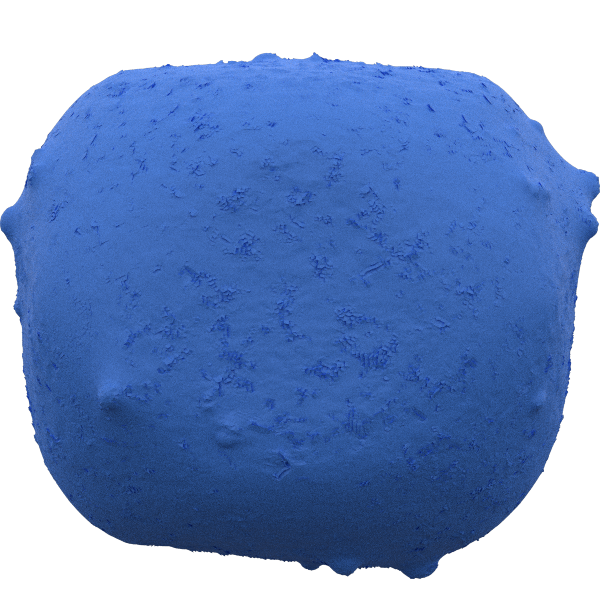

In [277]:
import fresnel
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=positions[cells].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=100, h=600, w=600)

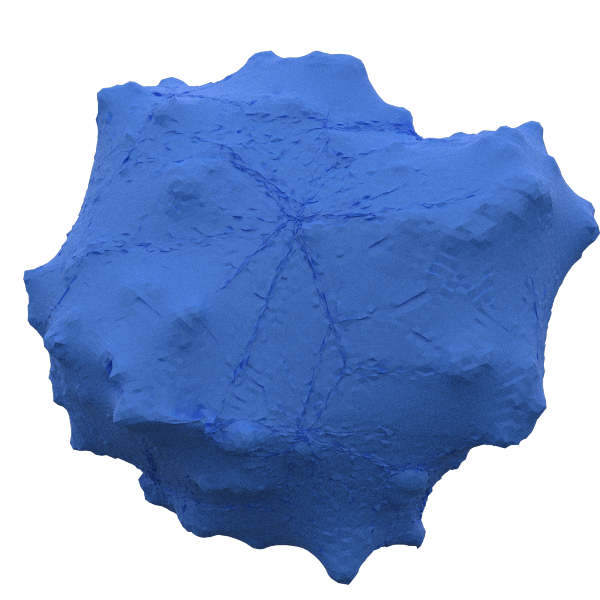

In [190]:
import fresnel
scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=positions[cells].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=200, h=600, w=600)